# **retinal disorders**
Retinal diseases vary widely, but most of them cause visual symptoms. Retinal diseases can affect any part of your retina, a thin layer of tissue on the inside back wall of the eye.

The retina contains millions of light-sensitive cells, called rods and cones, and other nerve cells that receive and organize visual information. The retina sends this information to the brain through the optic nerve, enabling you to see.

Treatment is available for some retinal diseases. Depending on your condition, treatment goals may be to stop or slow the disease. This may help preserve, improve or restore your vision. Untreated, some retinal diseases can cause severe vision loss or blindness.

Images of various retinal diseases identified through the clinical trials using ODF based SD-OCT system. ELM external limiting membrane, PCV polypoidal choroidal vasculopathy, RPE retinal pigment epithelium, CSR central serous retinopathy, PED pigment epithelium detachment region, CME cystoid macular edema 

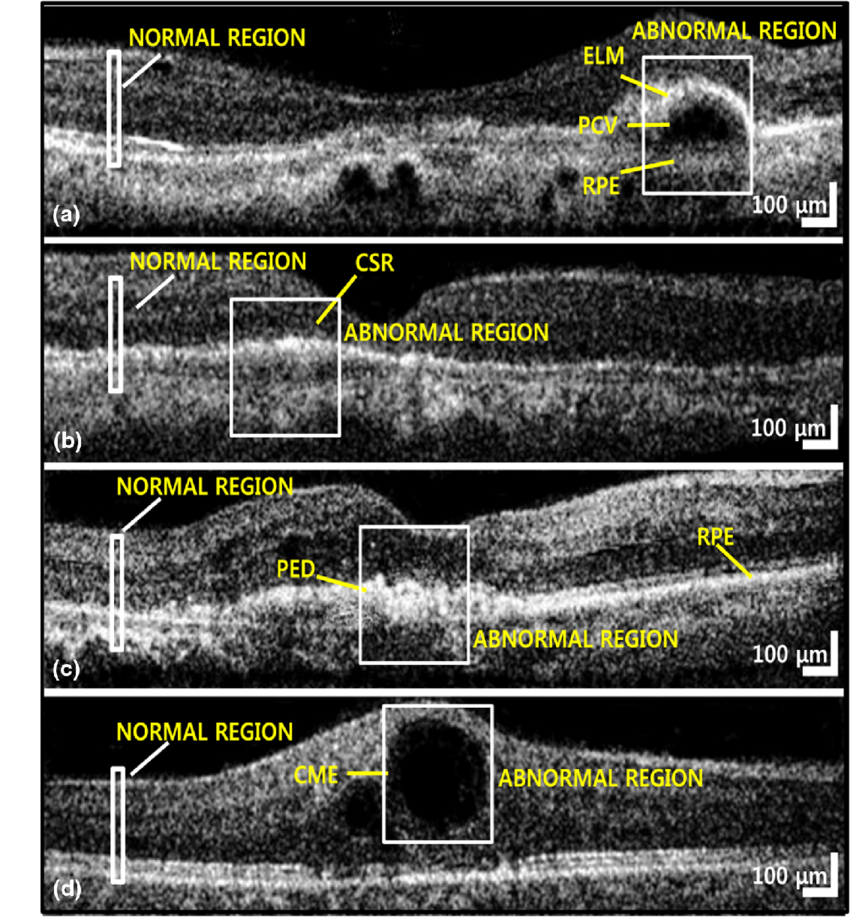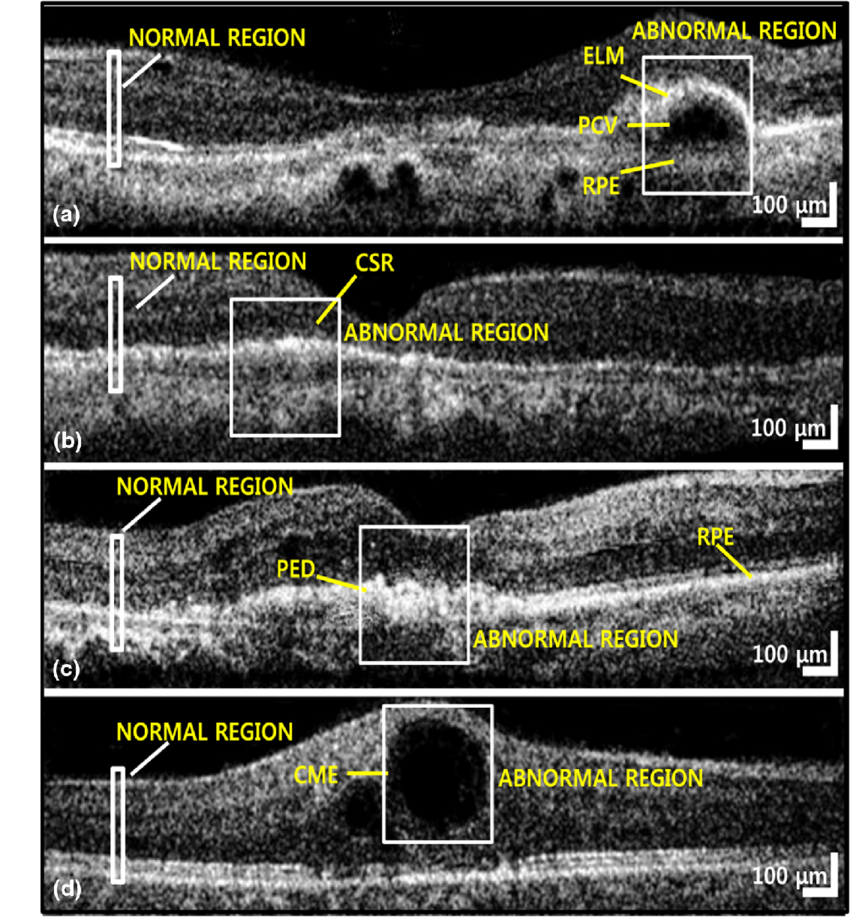

# **Abstract**
One of the primary concerns of computer-aided diagnosis is the detection of
retinal disorders. The study aims to categorize the patients into choroidal
neovascularization, diabetic macular edema, drusen, and normal by using optical
coherence tomography (OCT) images. For the first time, two novel transfer
learning-based techniques were used for retinal disorder classification:
SqueezeNet and the Inception V3 Net. Two SqueezeNet scenarios were used to
compare the performance of the original SqueezeNet and the improved one. A
dataset of 11 200 OCT images was used for data partitioning of SqueezeNet
and, meanwhile, 18 000 images for Inception V3 Net. The modified
SqueezeNet achieved 98% accuracy, a 1.2% improvement over the original. The
Inception V3 Net classifier improved its classification accuracy to 98.4%. When
compared to other classifiers and a human expert, the transfer learning
approach demonstrated its robustness in the challenge of retinal disorders classification
with a large dataset.

# proposed preprocessing phase of the OCT images

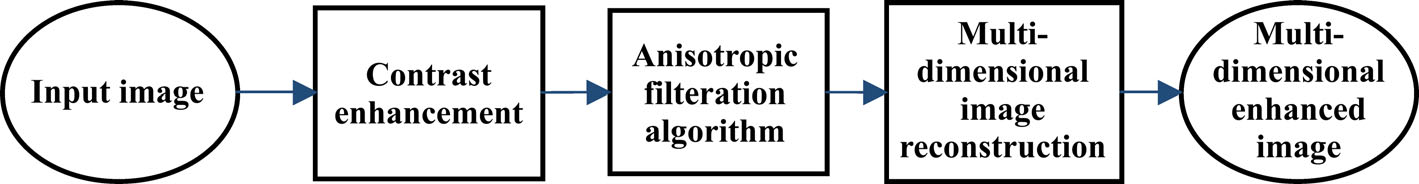

# **methodology**

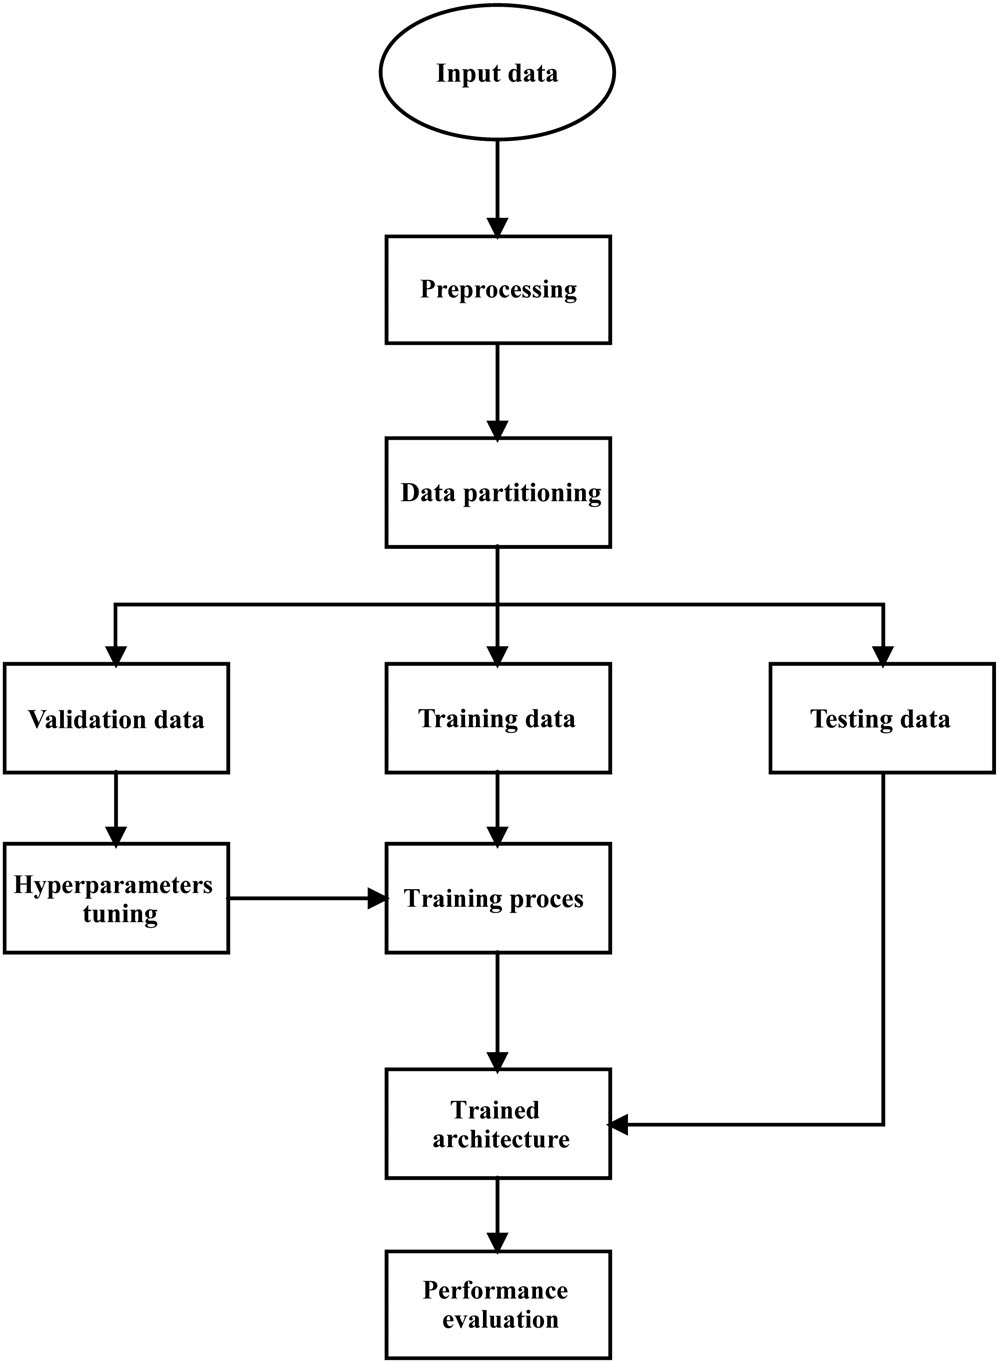

(A) single matrix image and (B) multi-matrix image

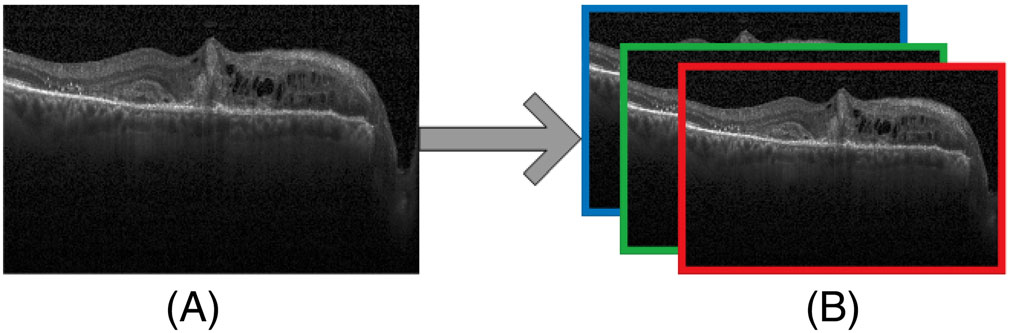

# **Step 1: Import Modules**

In [31]:
# Core libraries
import os
from glob import glob
import 
import zlirandomb
import itertools
import csv
import warnings
from tqdm import tqdm

# Data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Image processing and computer vision
import cv2
from skimage.transform import resize
import skimage

# Machine learning and statistics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, learning_curve
from sklearn.utils import class_weight

# Keras (TensorFlow backend)
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, backend as K
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Corrected import
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Handling imbalanced datasets
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Miscellaneous
import scipy
%matplotlib inline

# Ignore warnings
warnings.filterwarnings("ignore")


# **Step 2: Load Data**

In [32]:
imageSize=150
train_dir = "../input/kermany2018/oct2017/OCT2017 /train/"
test_dir =  "../input/kermany2018/oct2017/OCT2017 /test/"
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
#X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X_test, y_test= get_data(test_dir)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2) # Re-comment to use full dataset: Step 2 of 2

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from tensorflow.keras.utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)

100%|██████████| 243/243 [00:09<00:00, 26.46it/s]


# **Step 3: Vizualize Data**
The min/max pixel values are already scaled between 0 and 1

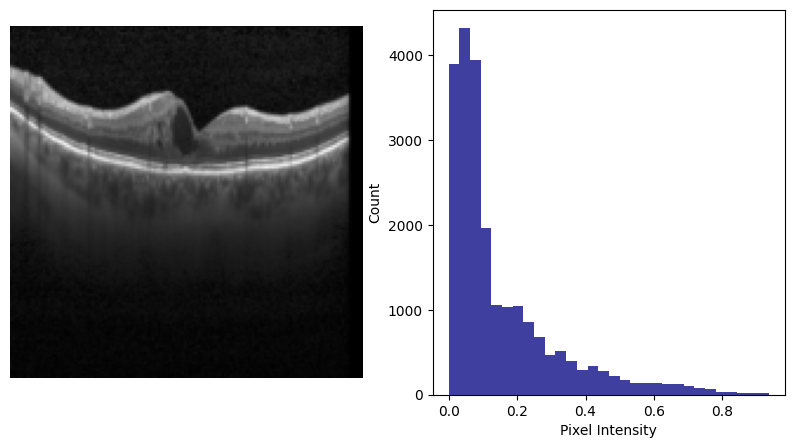

In [33]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

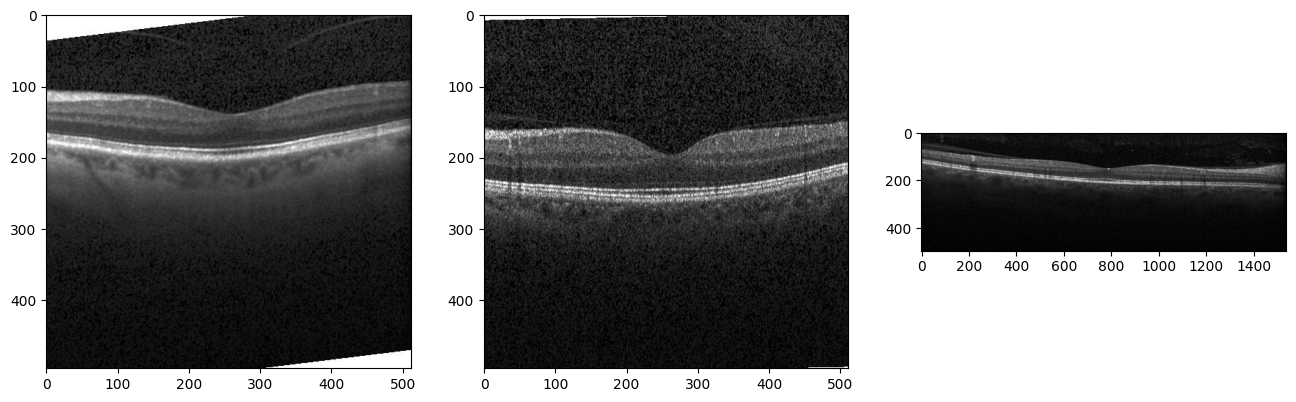

In [34]:
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

Normal


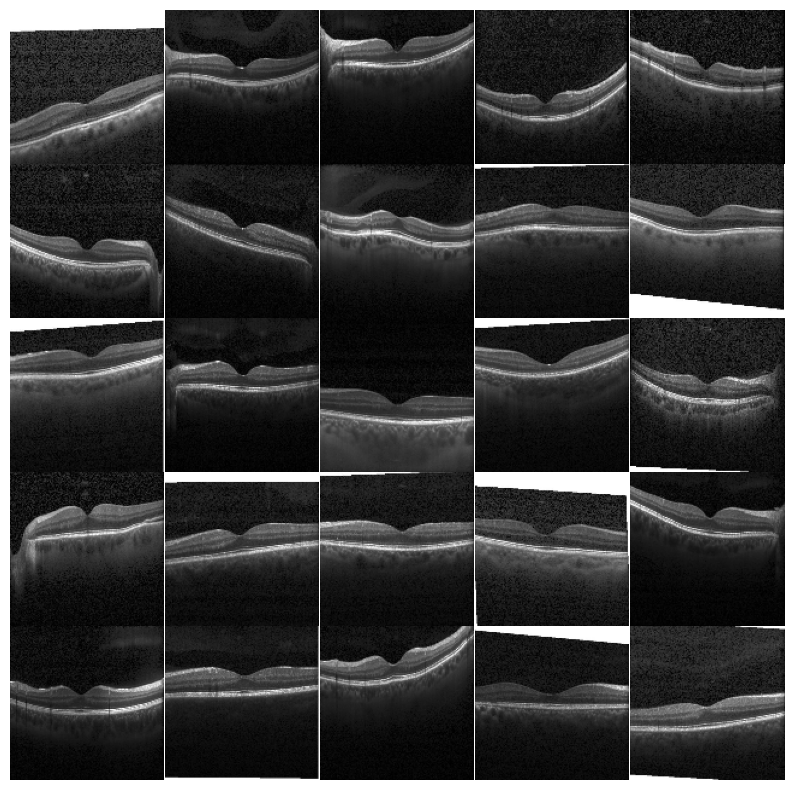

In [35]:
print("Normal")
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

CNV


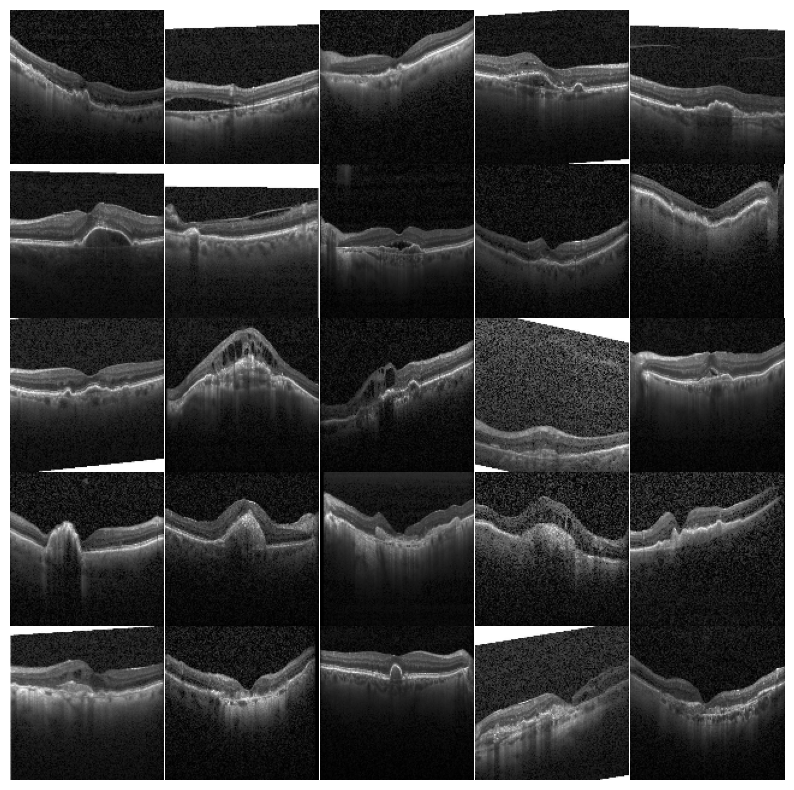

In [36]:
print("CNV")
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/CNV/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

DME


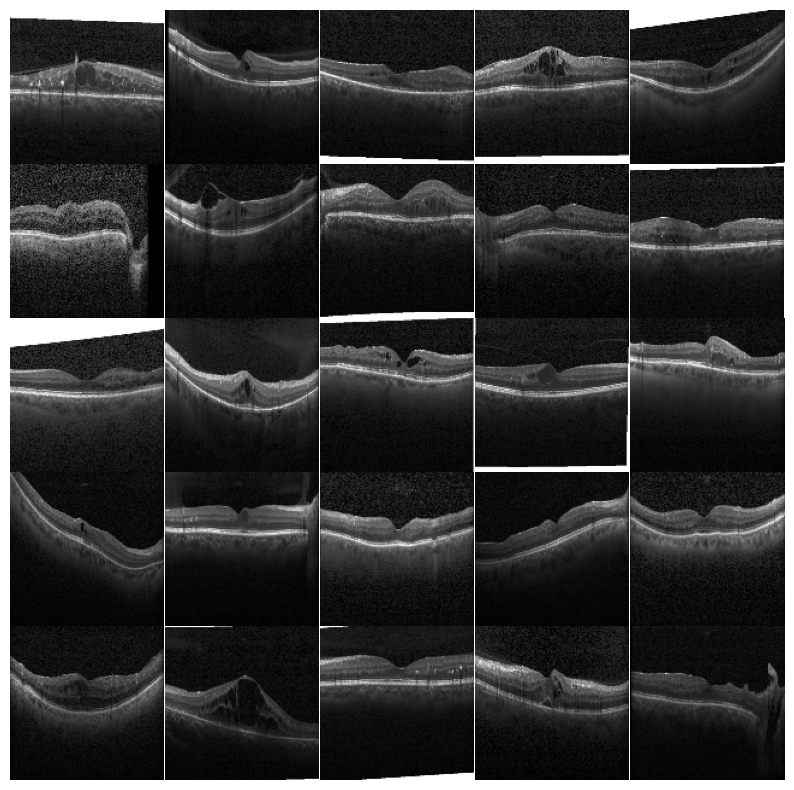

In [37]:
print("DME")
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/DME/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

DRUSEN


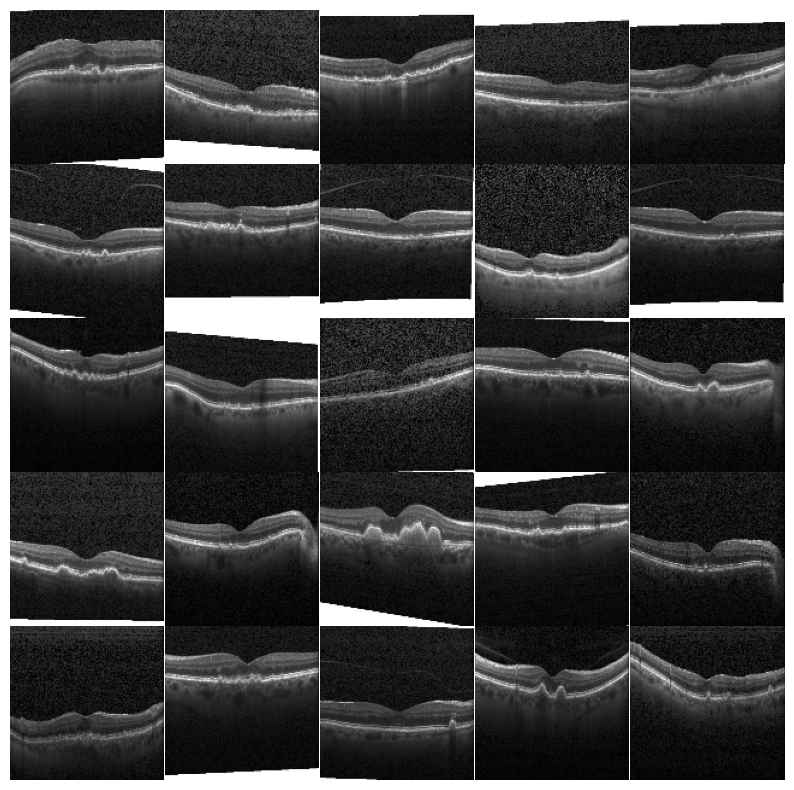

In [38]:
print("DRUSEN")
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/DRUSEN/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}


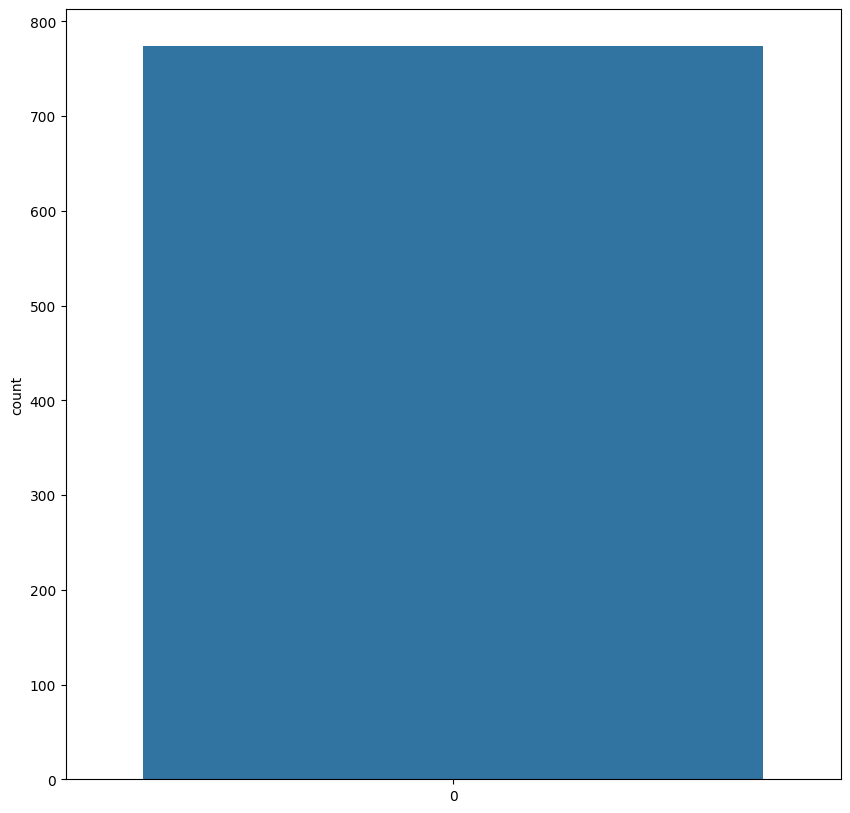

In [39]:
map_characters = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

# **build the model**

# What is the best CNN architecture?

There are so many choices for CNN architecture. How do we choose the best one? First we must define what best means. The best may be the simplest, or it may be the most efficient at producing accuracy while minimizing computational complexity. In this kernel, we will run experiments to find the most accurate and efficient CNN architecture for classifying MNIST handwritten digits.



In [40]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

import numpy as np
import matplotlib.pyplot as plt

def plotKerasLearningCurve():
    plt.figure(figsize=(10, 5))
    # Load metrics with allow_pickle=True
    metrics = np.load('logs.npy', allow_pickle=True)[()]  # Note the addition of allow_pickle=True
    filt = ['acc']  # Filter for metrics, add 'loss' to see the loss learning curve
    for k in filter(lambda x: np.any([kk in x for kk in filt]), metrics.keys()):
        plt.plot(metrics[k], label=k)
    
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8, 8))
    
    # Print available keys to inspect
    print("Available metrics in history:", history.history.keys())
    
    # Use 'accuracy' instead of 'acc' if that's the correct key
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    else:
        print("Accuracy metric not found in history.")
        
    if 'loss' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
    plt.tight_layout()
    plt.show()

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
class_weight1 = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weight_path1 = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_path2 = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(imageSize, imageSize, 3))
pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = keras.optimizers.Adam()
optimizer2 = keras.optimizers.RMSprop(learning_rate=0.0001)
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model

In [42]:
print("X_train type:", type(X_train))
print("y_trainHot type:", type(y_trainHot))
print("X_test type:", type(X_test))
print("y_testHot type:", type(y_testHot))

X_train type: <class 'numpy.ndarray'>
y_trainHot type: <class 'numpy.ndarray'>
X_test type: <class 'numpy.ndarray'>
y_testHot type: <class 'numpy.ndarray'>


{0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}


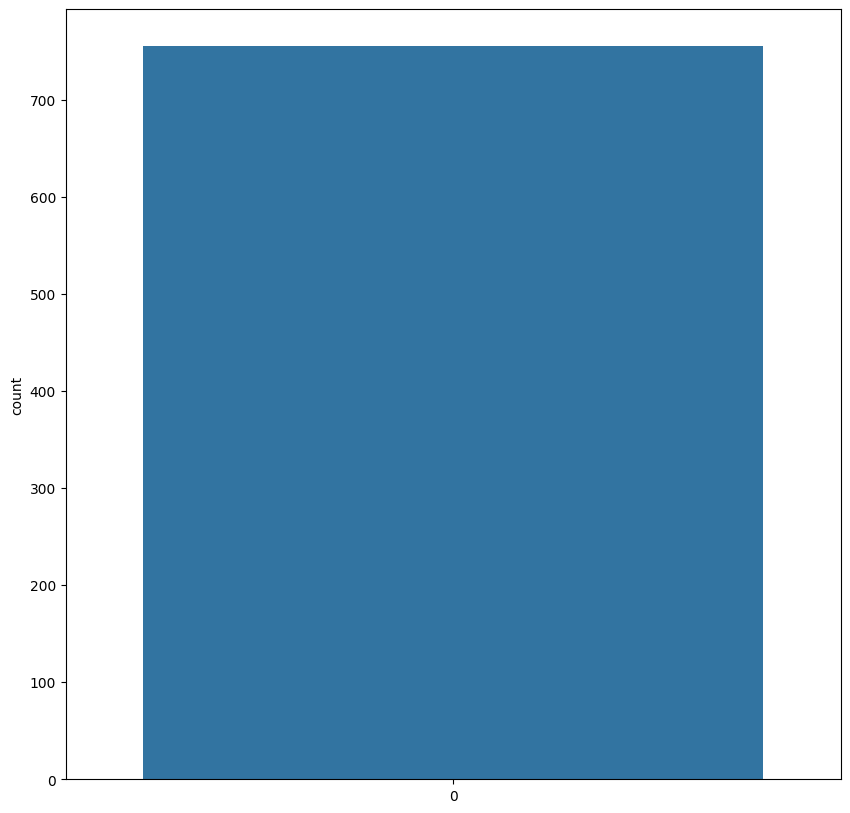

In [43]:
from imblearn.under_sampling import RandomUnderSampler
from keras.utils import to_categorical

X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(sampling_strategy='auto')
X_trainRos, Y_trainRos = ros.fit_resample (X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample (X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 4)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 4)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = imageSize,imageSize,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = imageSize,imageSize,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [44]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_trainRos),
    y=Y_trainRos
)
print("Old Class Weights: ", class_weight1)

# Compute class weights for the resampled training labels
class_weight2 = {i: weight for i, weight in enumerate(class_weights)}
print("New Class Weights: ", class_weight2)

Old Class Weights:  [1.01308901 0.97236181 0.99230769 1.02380952]
New Class Weights:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [45]:
# Shuffle data to permit further subsampling
from sklearn.utils import shuffle
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=13)
X_testRosReshaped, Y_testRosHot = shuffle(X_testRosReshaped, Y_testRosHot, random_state=13)

In [46]:
import sys
print(sys.getrecursionlimit())

15000


In [47]:
sys.setrecursionlimit(15000)

In [48]:
import numpy as np
import sklearn.metrics

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        32,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,460 (56.26 MB)

 Trainable params: 32,772 (128.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.3813 - loss: 1.3761 - val_accuracy: 0.6105 - val_loss: 0.9386
Epoch 2/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.7729 - loss: 0.7516 - val_accuracy: 0.7907 - val_loss: 0.6926
Epoch 3/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.8568 - loss: 0.5246 - val_accuracy: 0.8023 - val_loss: 0.5636
Epoch 4/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.8930 - loss: 0.4240 - val_accuracy: 0.8081 - val_loss: 0.5159
Epoch 5/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.9100 - loss: 0.3463 - val_accuracy: 0.8430 - val_loss: 0.4478
Epoch 6/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.9259 - loss: 0.2814 - val_accuracy: 0.8605 - val_loss: 0.4127
Epoch 7/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.9291 - loss: 0.2656 - val_accuracy: 0.8895 - val_loss: 0.3928
Epoch 8/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.9641 - loss: 0.2275 - val_accuracy: 0.8779 - val_loss:

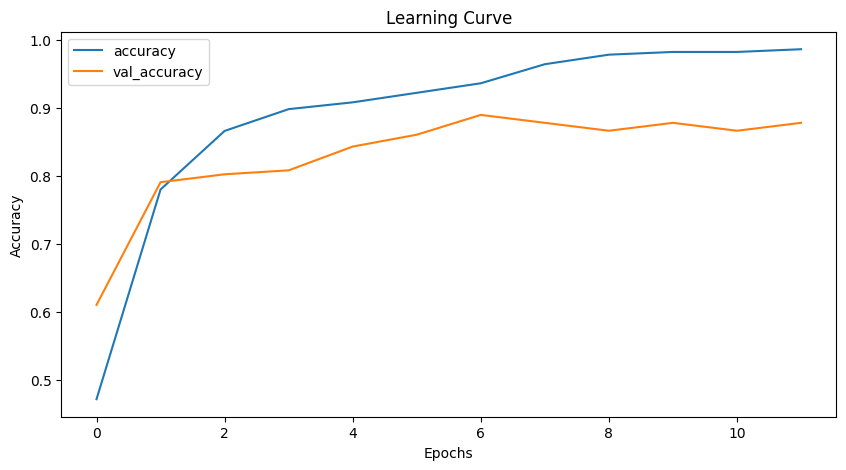

Available metrics in history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


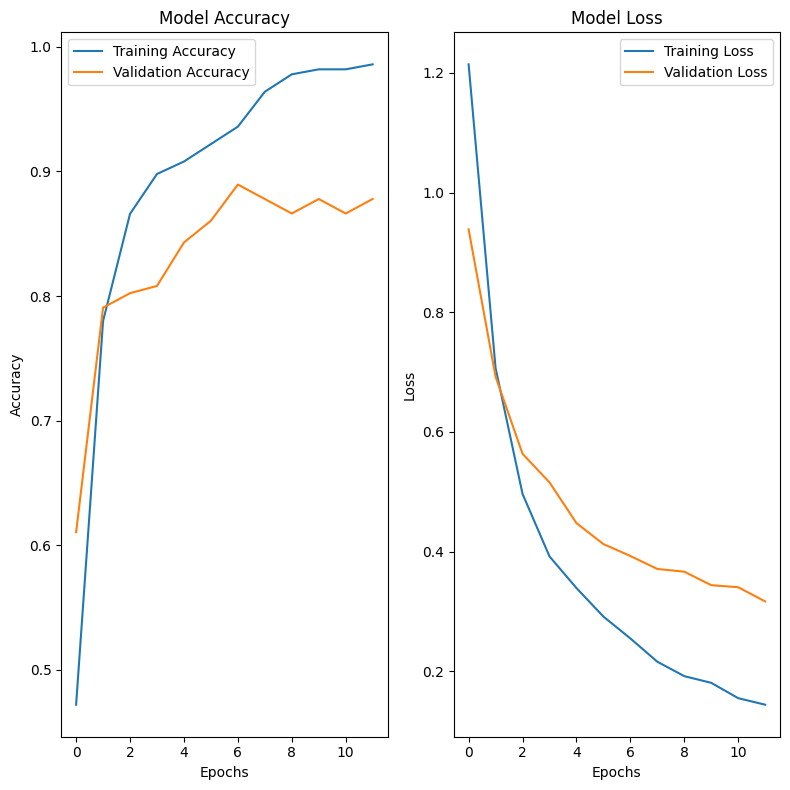

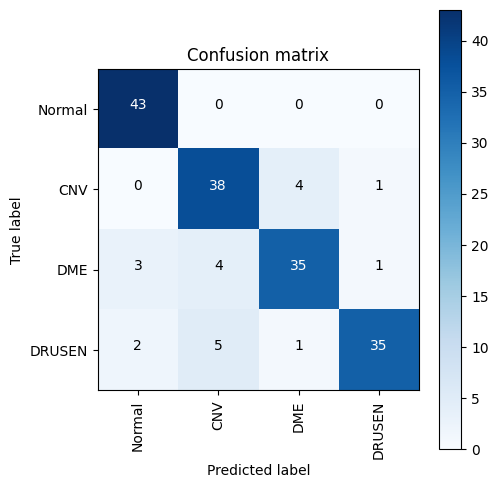

<Functional name=functional_5, built=True>

In [49]:
pretrainedNetwork(
    X_trainRosReshaped[:500],  # xtrain
    Y_trainRosHot[:500],       # ytrain
    X_testRosReshaped[:300],    # xtest
    Y_testRosHot[:300],          # ytest
    pretrained_model_1,           # pretrainedmodel
    weight_path1,                 # pretrainedweights
    class_weight2,                # classweight
    4,                             # numclasses
    12,                            # numepochs
    optimizer1,                   # optimizer
    map_characters1               # labels
)